In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import matplotlib.pyplot as plt
import bempp.api
from bempp.api import shapes
import bempp_cavity

# Define Mesh

In [3]:
ELEMENT_SIZE = 0.5
LENGTH_CAVITY = 1
LENGTH_WALL = 2

In [4]:
inner_wall = shapes.cube(
    length=LENGTH_CAVITY, h=ELEMENT_SIZE,
    origin=(-LENGTH_CAVITY/2, -LENGTH_CAVITY/2, -LENGTH_CAVITY/2)
)
outer_wall = shapes.cube(
        length=LENGTH_WALL, h=ELEMENT_SIZE,
        origin=(-LENGTH_WALL/2, -LENGTH_WALL/2, -LENGTH_WALL/2)
)
grid = bempp_cavity.create_grid(outer_wall, inner_wall)

In [5]:
Ks = [1, 2, 1]
MUs = [1, 1, 1]
wave = bempp_cavity.IncidentWave(Ks[0], MUs[0])

1 1


In [6]:
model = bempp_cavity.Model(grid, Ks, MUs, wave)

In [40]:
sol_1 = model.solve()

In [41]:
sol_2 = model.solve(preconditioner='diagonal')

In [46]:
sol_3 = model.solve(preconditioner='self')

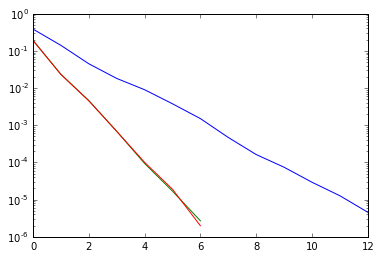

In [47]:
plt.semilogy(sol_1.residuals)
plt.semilogy(sol_2.residuals)
plt.semilogy(sol_3.residuals)

In [43]:
sol_1.info

{'matvec_count': 312,
 'status': 0,
 'time_assemble': 0.052607999999963795,
 'time_solve': 17.239721000000372}

In [44]:
sol_2.info

{'matvec_count': 280,
 'status': 0,
 'time_assemble': 0.06139500000017506,
 'time_solve': 12.784157999999934}

In [48]:
sol_3.info

{'matvec_count': 336,
 'status': 0,
 'time_assemble': 0.054474000000027445,
 'time_solve': 12.824708999999984}

In [9]:
model.system.get_memory_size()

666538

In [29]:
x = sol_2.system.operator.weak_form()
x[0, 0].memory


17417.109375

1 2 1 1
[2916, 9184, 36300]
cavity
wall
exterior


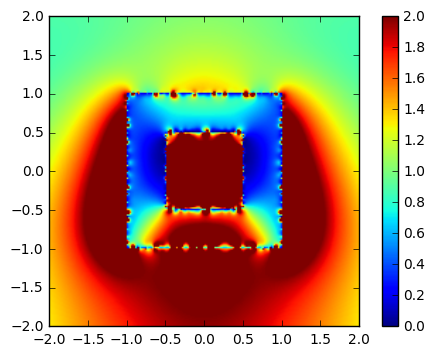

In [16]:
sol_2.plot()

1 2 1 1
[2916, 9184, 36300]
cavity
wall
exterior


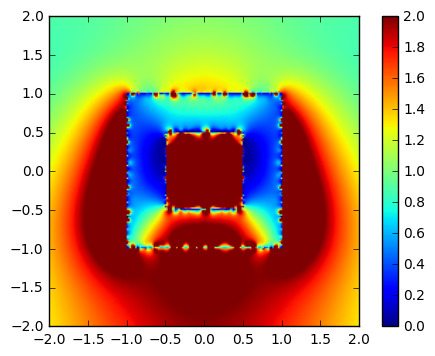

In [17]:
sol_1.plot()

# Notes

In [ ]:
# bempp_cavity.imshow(grid)

# shows the grid without the solution, black lines for boundaries

In [ ]:
wave = bempp_cavity.IncidentWave()

In [ ]:
model = bempp_cavity.Model(
    grid, [kw, k1, k2, k3], [muw, mu1, mu2, mu3], wave
    spaces='default',
)

In [ ]:
model.calc_stats() # matvecs? memory? wave number to element size


In [ ]:
sol = model.solve(preconditioner='diagonal', tol=1e-5)

In [ ]:
bempp_cavity.imshow(model, sol)
# shows implot

In [ ]:
plt.plot(info.residuals)
# dictionary with residuals and other information:
# info.runtime # how long it took to run
# info.memory


In [ ]:
model.matvecs # or info.matvecs?

In [37]:
bempp.api.MATVEC_COUNT

944